## Regression

## Insurance Forecast by using Linear Regression

# About this Dataset

The dataset is available on GitHub [here](https://github.com/stedy/Machine-Learning-with-R-datasets).

Columns:

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('insurance.csv')

Today we will explore a data set dedicated to the cost of treatment of different patients. The cost of treatment depends on many factors: diagnosis, type of clinic, city of residence, age and so on. We have no data on the diagnosis of patients. But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis. In any case, I wish you to be healthy! Let's look at our data.

## Exploration Data Analysis (EDA)

In [2]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Checking Missing Value

In [3]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

A good day is when there is no "NaN"in the data :D Let's look at our data to understand something about it. Since we are primarily interested in the amount of costs see what posts are more correlated with charges. For a start, we will encode categorical features

## Convert categorical features into numerical

In [4]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)

# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)

#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

In [5]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,2205.98080
1335,18,0,36.850,0,0,2,1629.83350
1336,21,0,25.800,0,0,3,2007.94500


Data Correlation

In [6]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

<AxesSubplot:>

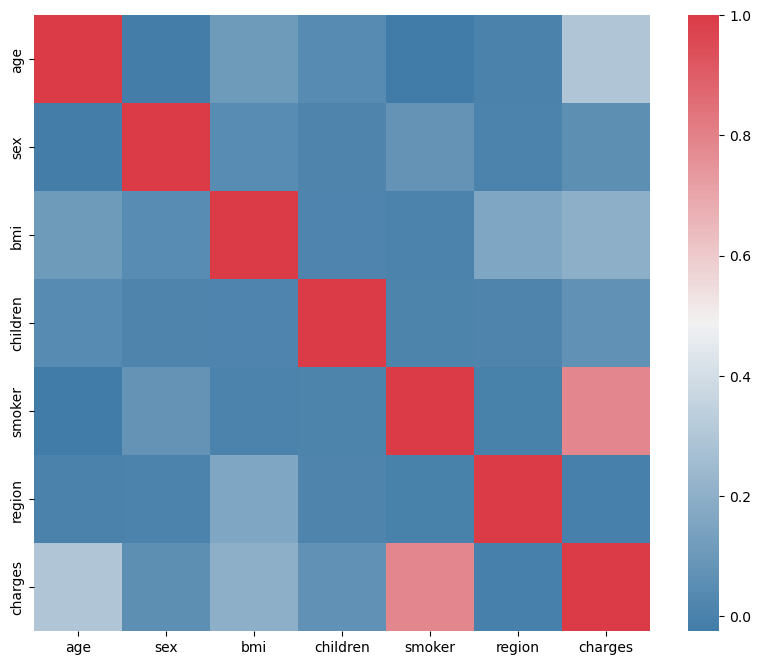

In [7]:
f, ax = pl.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

A strong correlation is observed only with the fact of smoking the patient. To be honest, I expected a higher correlation with bmi. Well. We investigate smoking in more detail.

First, let's look at the distribution of charges. This will help us to know how much patients spend on treatment on average. We're importing another useful library that we'll need a few more times. Although it's not necessary, why not :D

In [8]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import scipy.special
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

Loading BokehJS ...

In [10]:
p = figure(title="Distribution of charges",tools="save",
            background_fill_color="#E8DDCB")
hist, edges = np.histogram(data.charges)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
p.xaxis.axis_label = 'x'
p.yaxis.axis_label = 'Pr(x)'
show(gridplot([p],ncols = 2, plot_width=400, plot_height=400, toolbar_location=None))

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

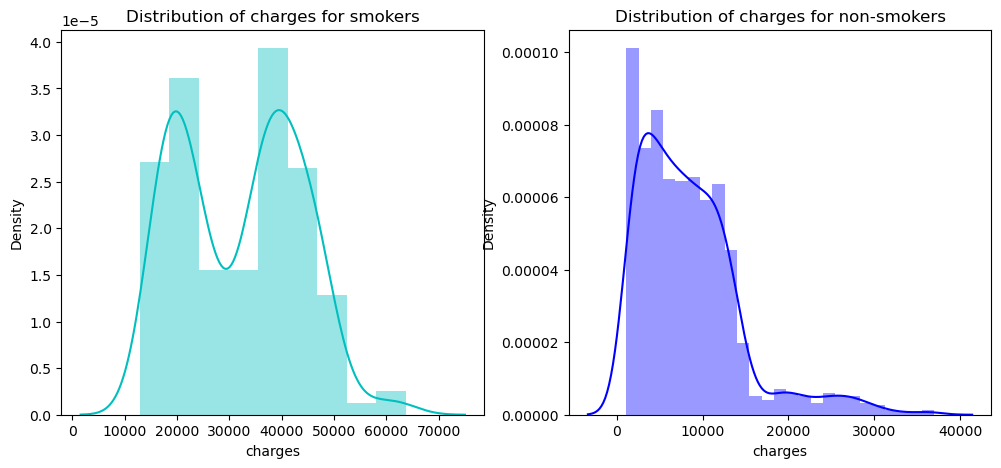

In [11]:
f= pl.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

Smoking patients spend more on treatment. But there is a feeling that the number of non-smoking patients is greater. Going to check it.

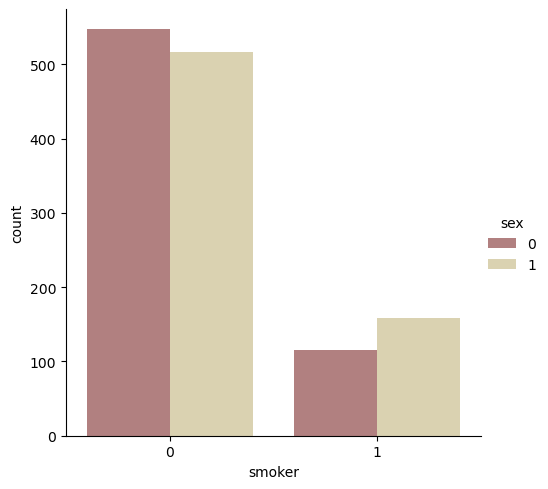

In [12]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=data)

Please note that women are coded with the symbol " 1 "and men - "0". Thus non-smoking people and the truth more. Also we can notice that more male smokers than women smokers. It can be assumed that the total cost of treatment in men will be more than in women, given the impact of smoking. Maybe we'll check it out later. And some more useful visualizations.

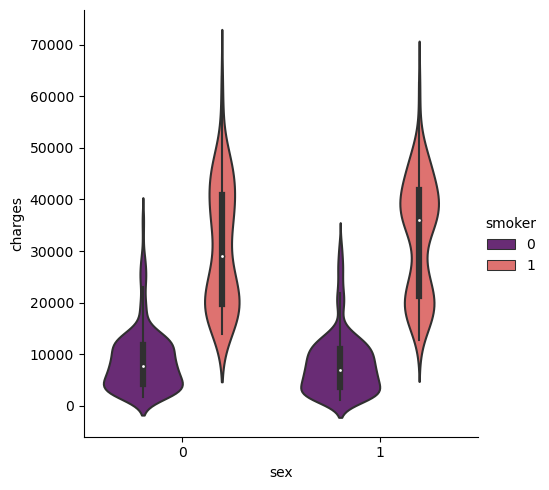

In [13]:
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=data, palette = 'magma')

<AxesSubplot:title={'center':'Box plot for charges of women'}, xlabel='charges', ylabel='smoker'>

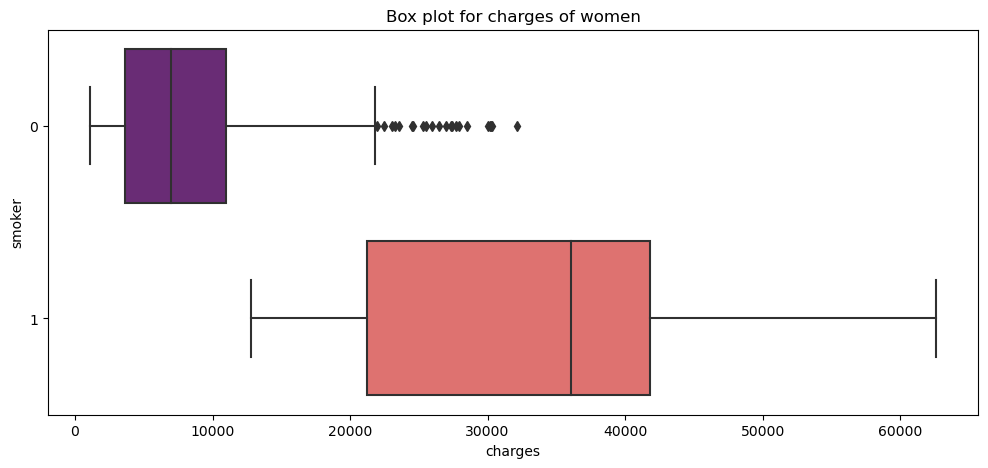

In [14]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 1)] , orient="h", palette = 'magma')

<AxesSubplot:title={'center':'Box plot for charges of men'}, xlabel='charges', ylabel='smoker'>

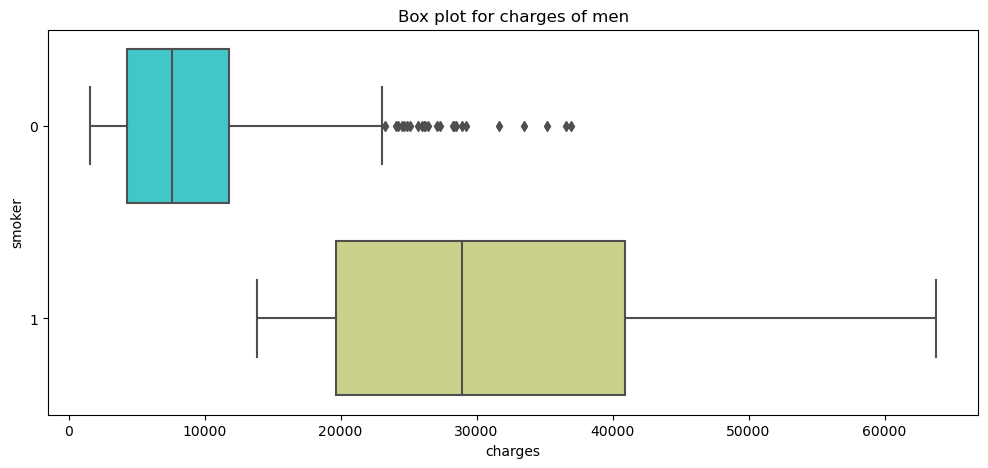

In [15]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 0)] , orient="h", palette = 'rainbow')

Now let's pay attention to the age of the patients. First, let's look at how age affects the cost of treatment, and also look at patients of what age more in our data set.

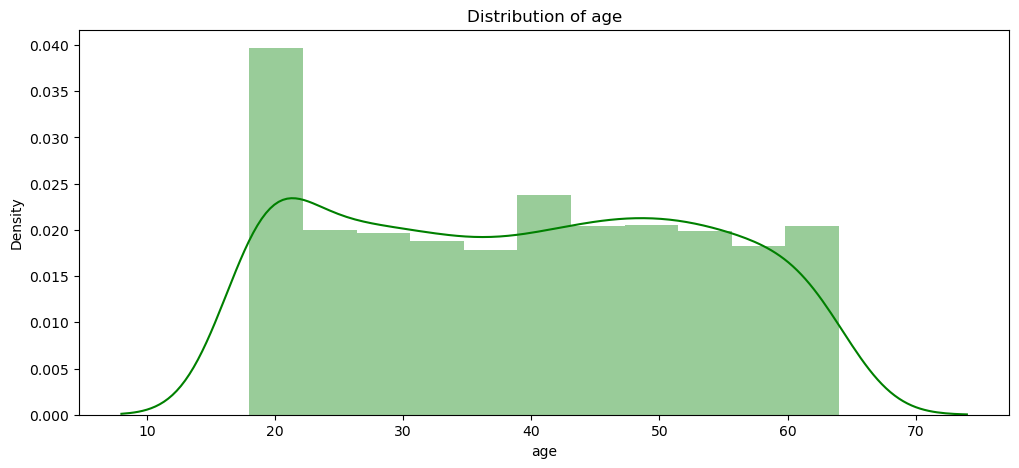

In [16]:
pl.figure(figsize=(12,5))
pl.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

We have patients under 20 in our data set. Im 18 years old. This is the minimum age of patients in our set. The maximum age is 64 years. My personal interest is whether there are smokers among patients 18 years.

Text(0.5, 1.0, 'The number of smokers and non-smokers (18 years old)')

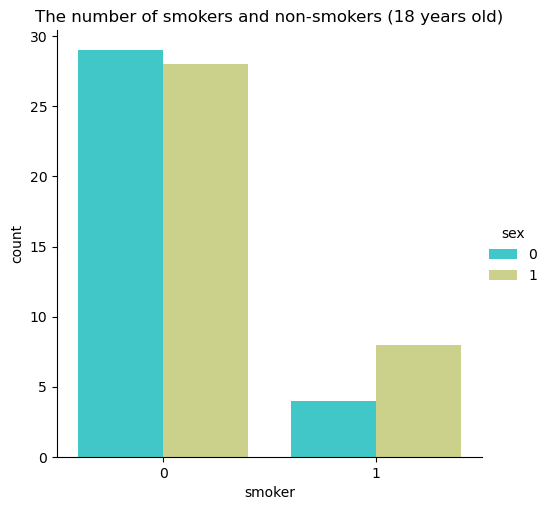

In [17]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="rainbow", data=data[(data.age == 18)])
pl.title("The number of smokers and non-smokers (18 years old)")

Oh. I was hoping the result would be different. 18 years old - a very young age. Does smoking affect the cost of treatment at this age?

<AxesSubplot:title={'center':'Box plot for charges 18 years old smokers'}, xlabel='charges', ylabel='smoker'>

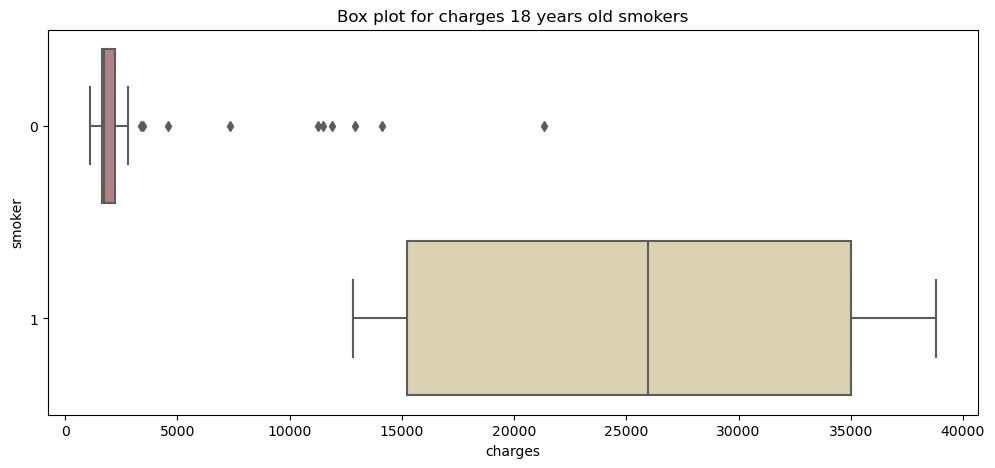

In [18]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges 18 years old smokers")
sns.boxplot(y="smoker", x="charges", data = data[(data.age == 18)] , orient="h", palette = 'pink')

Oh. As we can see, even at the age of 18 smokers spend much more on treatment than non-smokers. Among non-smokers we are seeing some " tails." I can assume that this is due to serious diseases or accidents. Now let's see how the cost of treatment depends on the age of smokers and non-smokers patients.

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

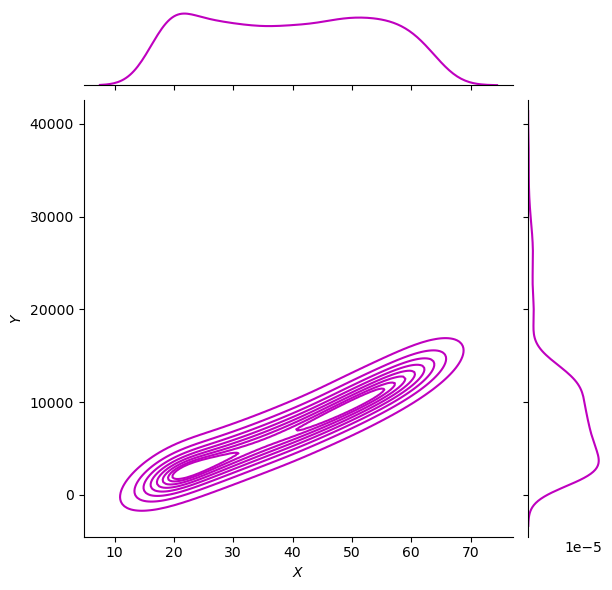

In [19]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="m")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

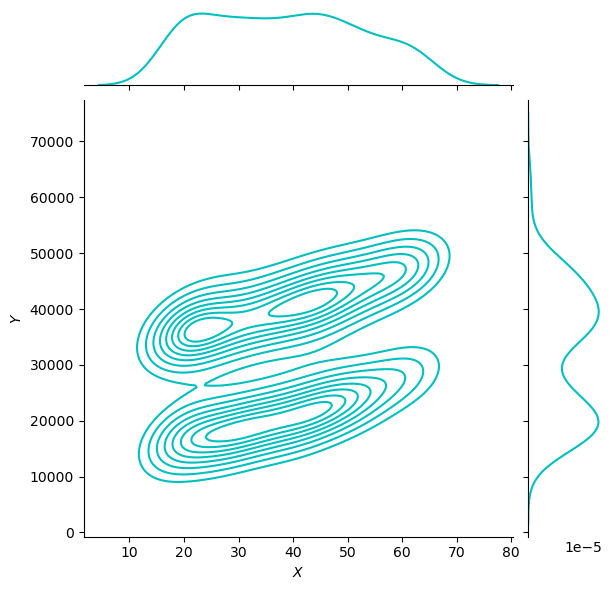

In [20]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="c")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for smokers')

In [21]:
#non - smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 0)].age,y=data[(data.smoker == 0)].charges, size=7, line_color="navy", fill_color="pink", fill_alpha=0.9)

show(p)

In [22]:
#smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 1)].age,y=data[(data.smoker == 1)].charges, size=7, line_color="navy", fill_color="red", fill_alpha=0.9)
show(p)

Text(0.5, 1.0, 'Smokers and non-smokers')

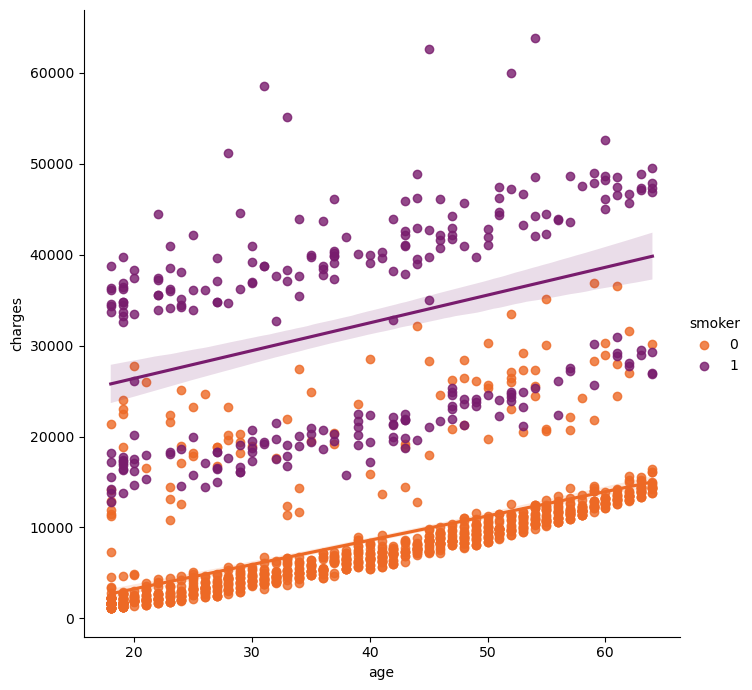

In [23]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

In non-smokers, the cost of treatment increases with age. That makes sense. So take care of your health, friends! In smoking people, we do not see such dependence. I think that it is not only in smoking but also in the peculiarities of the dataset. Such a strong effect of Smoking on the cost of treatment would be more logical to judge having a set of data with a large number of records and signs. But we work with what we have! Let's pay attention to bmi. I am surprised that this figure but affects the cost of treatment in patients. Or are we on a diet for nothing?

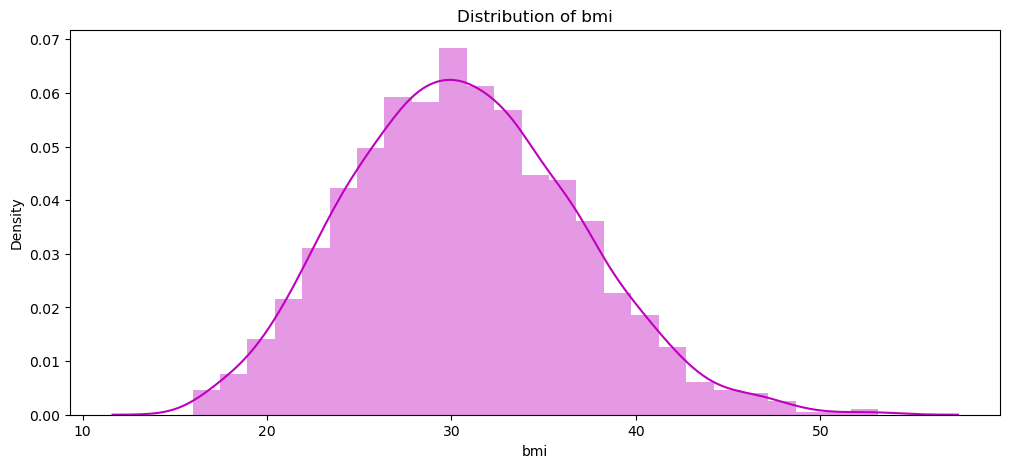

In [24]:
pl.figure(figsize=(12,5))
pl.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = 'm')

There's something insanely beautiful about this distribution, isn't there?
The average BMI in patients is 30. I think I should go to the great Google with a question about this indicator.

With a value equal to 30 starts obesity. I also calculated my BMI and now I can safely eat a sandwich. Let's start to explore! First, let's look at the distribution of costs in patients with BMI greater than 30 and less than 30.

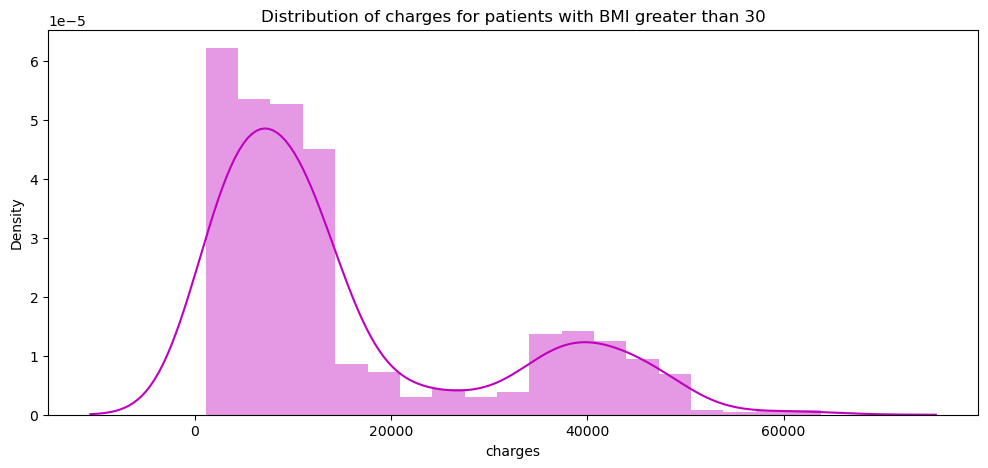

In [25]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI greater than 30")
ax = sns.distplot(data[(data.bmi >= 30)]['charges'], color = 'm')

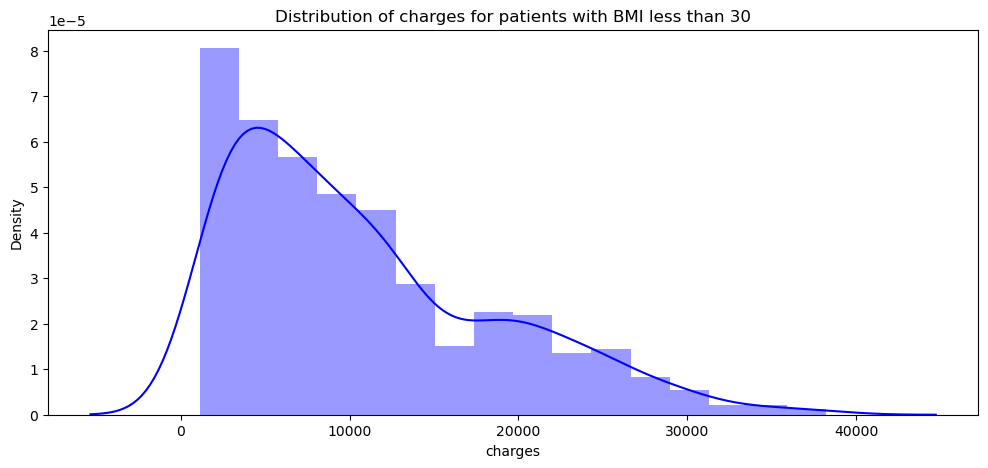

In [26]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], color = 'b')

Patients with BMI above 30 spend more on treatment!

Text(0.5, 1.0, 'Distribution of bmi and charges')

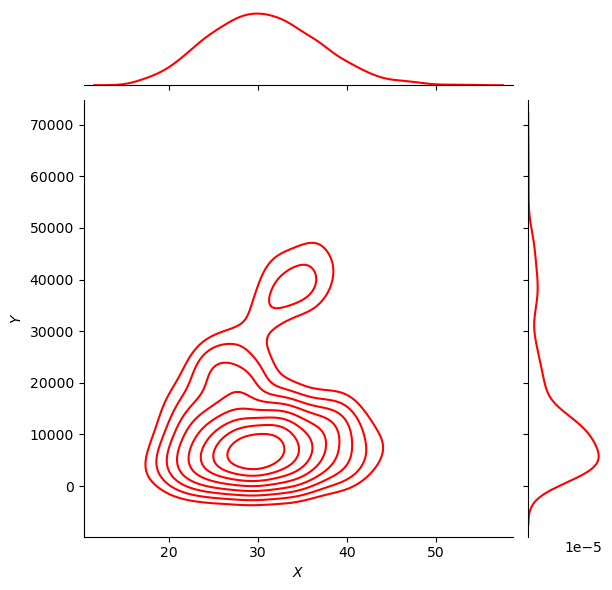

In [27]:
g = sns.jointplot(x="bmi", y="charges", data = data,kind="kde", color="r")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of bmi and charges')

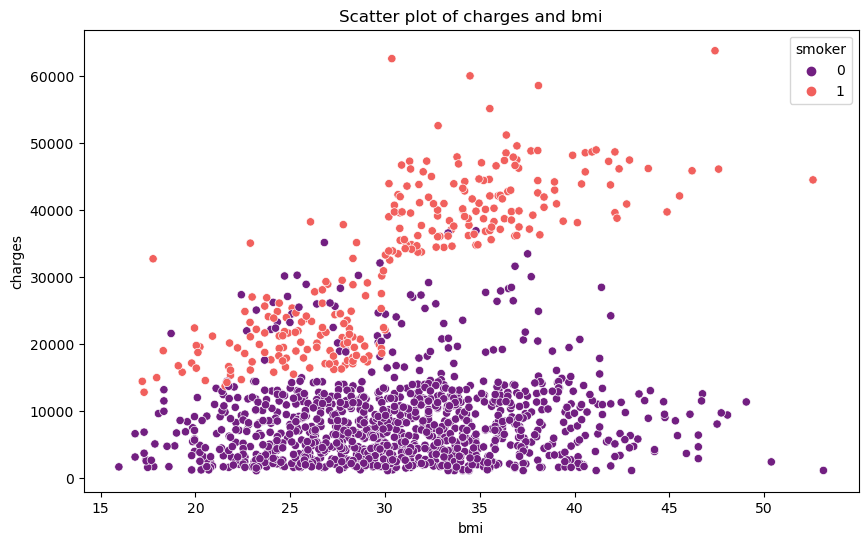

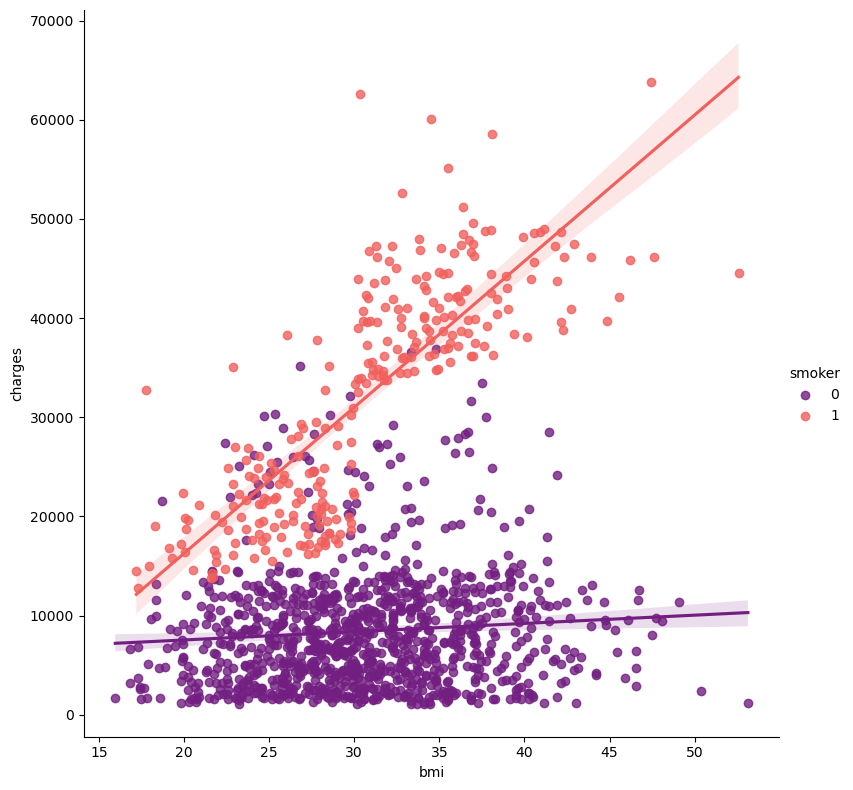

In [28]:
pl.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of charges and bmi')

sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)

Let's pay attention to children. First, let's see how many children our patients have.

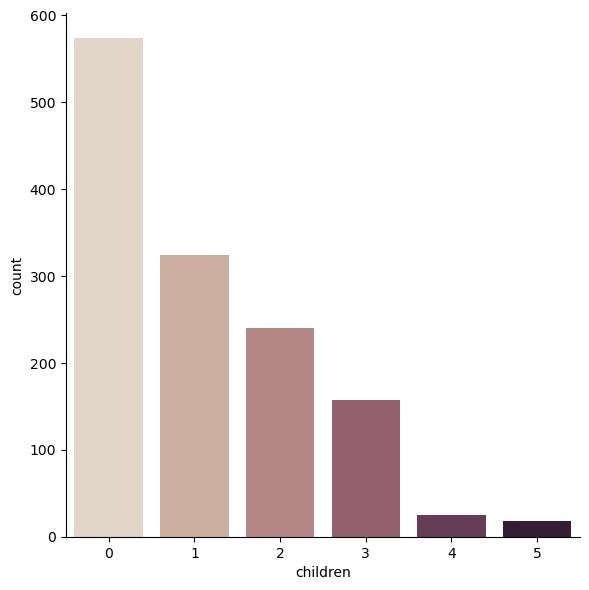

In [29]:
sns.catplot(x="children", kind="count", palette="ch:.25", data=data, size = 6)

Most patients do not have children. Perfectly that some have 5 children! Children are happiness:) I wonder if people who have children smoke.

Text(0.5, 1.0, 'Smokers and non-smokers who have childrens')

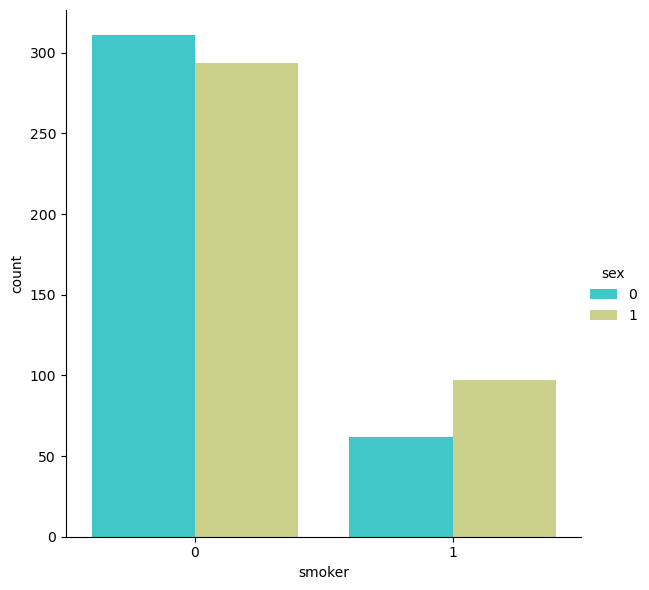

In [30]:
sns.catplot(x="smoker", kind="count", palette="rainbow",hue = "sex",
            data=data[(data.children > 0)], size = 6)
ax.set_title('Smokers and non-smokers who have childrens')

But I am glad that non-smoking parents are much more!

I have a few more ideas for exploring this dataset. I will soon implement them. And now we are going to predict the cost of treatment. Let's start with the usual linear regression.

## Assign $x$ and $y$


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [8]:
x = data.drop(['charges'], axis = 1)
y = data.charges

## Split dataset into training set and testing set

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)

## Model

In [10]:
lr = LinearRegression().fit(x_train,y_train)

## Predict the result and score(accuracy) model

In [11]:
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(lr.score(x_test,y_test))

0.7962732059725786


Not bad for such a lazy implementation, even without data normalization:D After all, the data will not always be so "good". So don't forget to pre-process the data. I'll show you all this later when I try to implement my own linear regression.

## Mean square error and <sup>R<\sup>

In [12]:
print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,y_train_pred),
mean_squared_error(y_test,y_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,y_train_pred),
r2_score(y_test,y_test_pred)))

MSE train data: 38050102.806, MSE test data: 32073628.560
R2 train data: 0.734, R2 test data: 0.796


## Plot the result

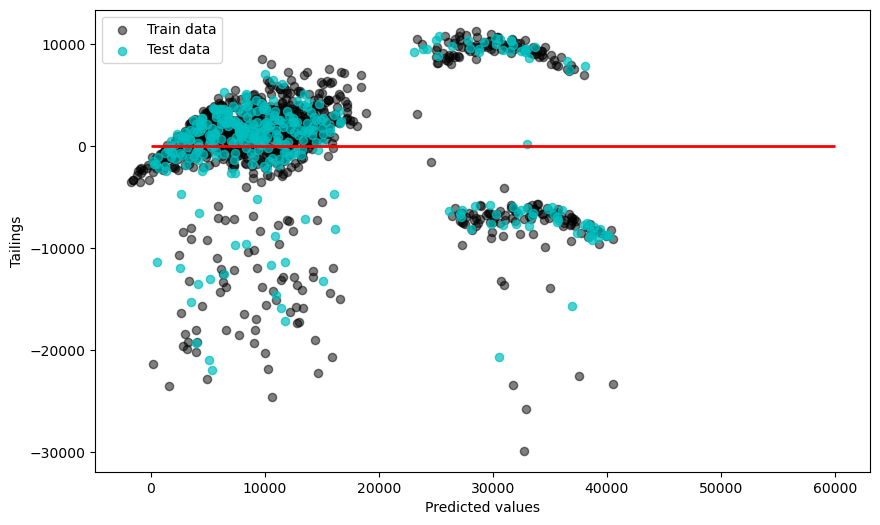

In [14]:
pl.figure(figsize=(10,6))

pl.scatter(y_train_pred, y_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
pl.scatter(y_test_pred, y_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.legend(loc = 'upper left')
pl.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
pl.show()

It is not good result. But we see a noticeable retraining of the algorithm on the training data. There are several ways to improve the result:
1. Adjust the training and testing sets
2. Optimize hyperparameters
3. Change algorithms
4. Data pre-processing/ cleaning
5. etc.